# Тематическая классификация длинных текстов - TFIDF и LogReg

## Краткие выводы по проведенным экспериментам

### Пайплайн-чемпион (для кастомной реализации TF-IDF и LogReg): 
(Stop word Removal + Lemmatizing) + TF-IDF (custom) + MinMaxScaler (sklearn) + LogReg (custom) + Adagrad + L2

### Оценка качества для лучшего пайплайна:
 - среднее значение функции потерь на обучении: 0.20902366936206818
 - доля верных ответов на обучении: 0.9983206646632491
 - среднее значение функции потерь на валидации: 0.8890098929405212
 - доля верных ответов на валидации: 0.8113382899628253

### Резюме:

1) Оптимальные варианты взвешивания — TF и TF-IDF. BIN, IDF дали более низкие значения оценки качества. \
2) Реализовал взвешивание с PMI (также попробовал TF-PMI): качество на тестовой выборке стало лучше. \
3) Лучший скейлер для задачи — MinMaxScaler. StandardScaler, RobustScaler показали себя хуже. В основном использовался MinMaxScaler из sklearn, т.к. кастомный реализован некорректно (min и max значения должны браться из тренировочной выборке и далее использоваться как на тренировочной, так и на тестовой). \
4) Добавление L2-регуляризации позволило избежать переобучения модели. \
5) Для препроцессинга использовались следующие методы: удаление стоп-слов, стемминг, лемматизация, тегирование именнованных сущностей, удаление именнованных сущностей. Лучше всего себя показали удаление стоп-слов и лемматизация. \
6) Попробовал вместо LogReg использовать MLP. В качестве функции активации попробовал и сигмоиду и ReLU, сигмоида показала себя лучше (accuracy немного увеличилось, но модель переобучается даже с регуляризацией). При использовании ReLU получилось довольно низкое качество на тестовой выборке. \
7) Были испробованы различные оптимизаторы: Adam, Adagrad, Adadelta, SGD, RMSprop. Лучше всех себя показали Adagrad и SGD. \
8) Извлечение признаков из N-грамм, ngram_range=(1,2): accuracy незначительно увеличилось, но модель переобучается даже с регуляризацией. \
9) Подкорректировал MIN_COUNT и MAX_DF (MAX_DF = 0.8 и MIN_COUNT = 4), извлекал признаки из N-грамм с диапазоном (1,2): accuracy незначительно увеличилось, но модель переобучается даже с регуляризацией. \
10) Модернизировал реализацию TF и IDF (и соответственно TF-IDF): добавил возможность использования сублинейного преобразования (sublinear_tf: bool, sublinear_df: bool). Но при использовании данных режимов при расчете матрицы признаков accuracy значительно снижается.

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/arturburiev/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [2]:
import warnings

warnings.filterwarnings("ignore")

import scipy.sparse
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import (
    tokenize_text_simple_regex,
    tokenize_corpus,
    generate_tokens_n_grams,
    build_vocabulary,
    calc_counter_matrix,
    calc_pmi,
    vectorize_texts,
    NER_preprocessing,
    spellchecking_preprocessing,
    stopword_removing_preprocessing,
    stemming_preprocessing,
    lemmatizing_preprocessing,
    SparseFeaturesDataset,
)
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

init_random_seed()

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/arturburiev/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Предобработка текстов и подготовка признаков

In [3]:
train_source = fetch_20newsgroups(subset="train")
test_source = fetch_20newsgroups(subset="test")

print("Количество обучающих текстов", len(train_source["data"]))
print("Количество тестовых текстов", len(test_source["data"]))
print()
print(train_source["data"][0].strip())

print()
print("Метка", train_source["target"][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Метка 7


### Подготовка признаков

In [4]:
# train_source["data"] = NER_preprocessing(train_source["data"])
# test_source["data"] = NER_preprocessing(test_source["data"])

In [5]:
train_tokenized = tokenize_corpus(train_source["data"])
test_tokenized = tokenize_corpus(test_source["data"])

print(" ".join(train_tokenized[0]))

from lerxst where thing subject what this nntp posting host rac3 organization university maryland college park lines wondering anyone there could enlighten this other door sports looked from late early called bricklin doors were really small addition front bumper separate from rest body this know anyone tellme model name engine specs years production where this made history whatever info have this funky looking please mail thanks brought your neighborhood lerxst


#### Генерация N-грамм токенов

In [6]:
NGRAM_RANGE = None

if NGRAM_RANGE is not None:
    train_tokenized = [
        generate_tokens_n_grams(tokenized_text, NGRAM_RANGE)
        for tokenized_text in train_tokenized
    ]

    test_tokenized = [
        generate_tokens_n_grams(tokenized_text, NGRAM_RANGE)
        for tokenized_text in test_tokenized
    ]

In [7]:
MAX_DF = 0.8
MIN_COUNT = 5

In [8]:
vocabulary, word_doc_freq = build_vocabulary(
    train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT, sublinear_df=False, smooth_df=False
)
UNIQUE_WORDS_N = len(vocabulary)
print("Количество уникальных токенов", UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 21628
[('that', 0), ('this', 1), ('have', 2), ('with', 3), ('writes', 4), ('article', 5), ('posting', 6), ('host', 7), ('nntp', 8), ('there', 9)]


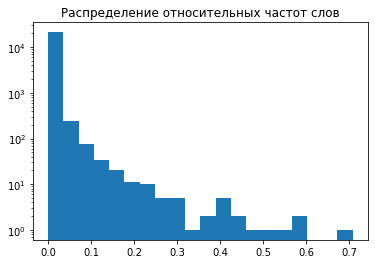

In [9]:
plt.hist(word_doc_freq, bins=20)
plt.title("Распределение относительных частот слов")
plt.yscale("log")

#### Применение остальных препроцессоров

In [10]:
preprocessors_for_applying = [
#     spellchecking_preprocessing,
    stopword_removing_preprocessing,
    lemmatizing_preprocessing,
#     stemming_preprocessing,
]


def apply_preprocessors(preprocessors, text_data):
    for prep in preprocessors_for_applying:
        text_data = prep(text_data)

    return text_data


train_tokenized = apply_preprocessors(preprocessors_for_applying, train_tokenized)
test_tokenized = apply_preprocessors(preprocessors_for_applying, test_tokenized)

In [11]:
VECTORIZATION_MODE = "tfidf"

train_counter_matrix = calc_counter_matrix(train_tokenized, vocabulary)
pmi_vec = (
    calc_pmi(train_counter_matrix, train_source["target"])
    if VECTORIZATION_MODE in ("tfpmi", "pmi")
    else None
)
train_vectors = vectorize_texts(
    train_counter_matrix, word_doc_freq, pmi_vec, mode=VECTORIZATION_MODE, sublinear_tf=False, scale=False
)

test_counter_matrix = calc_counter_matrix(test_tokenized, vocabulary)
test_vectors = vectorize_texts(
    test_counter_matrix, word_doc_freq, pmi_vec, mode=VECTORIZATION_MODE, sublinear_tf=False, scale=False
)

#### Стандартизация с sklearn

In [12]:
scaler = MinMaxScaler()
train_vectors = scipy.sparse.csr_matrix(scaler.fit_transform(train_vectors.toarray()))
test_vectors = scipy.sparse.csr_matrix(scaler.transform(test_vectors.toarray()))

In [13]:
print("Размерность матрицы признаков обучающей выборки", train_vectors.shape)
print("Размерность матрицы признаков тестовой выборки", test_vectors.shape)
print()
print("Количество ненулевых элементов в обучающей выборке", train_vectors.nnz)
print(
    "Процент заполненности матрицы признаков {:.2f}%".format(
        train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])
    )
)
print()
print("Количество ненулевых элементов в тестовой выборке", test_vectors.nnz)
print(
    "Процент заполненности матрицы признаков {:.2f}%".format(
        test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])
    )
)

Размерность матрицы признаков обучающей выборки (11314, 21628)
Размерность матрицы признаков тестовой выборки (7532, 21628)

Количество ненулевых элементов в обучающей выборке 957877
Процент заполненности матрицы признаков 0.39%

Количество ненулевых элементов в тестовой выборке 611286
Процент заполненности матрицы признаков 0.38%


### Распределение весов признаков

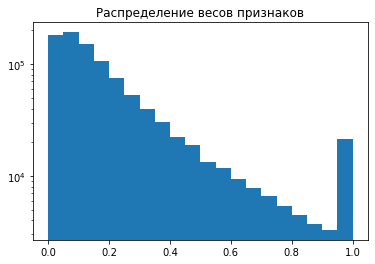

In [14]:
plt.hist(train_vectors.data, bins=20)
plt.title("Распределение весов признаков")
plt.yscale("log")

### Распределение классов

In [15]:
UNIQUE_LABELS_N = len(set(train_source["target"]))
print("Количество уникальных меток", UNIQUE_LABELS_N)

Количество уникальных меток 20


Text(0.5, 1.0, 'Распределение меток в обучающей выборке')

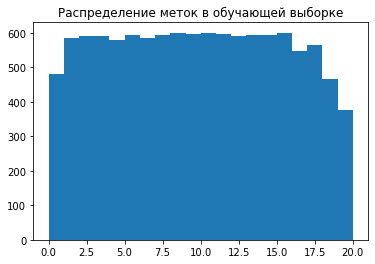

In [16]:
plt.hist(train_source["target"], bins=np.arange(0, 21))
plt.title("Распределение меток в обучающей выборке")

Text(0.5, 1.0, 'Распределение меток в тестовой выборке')

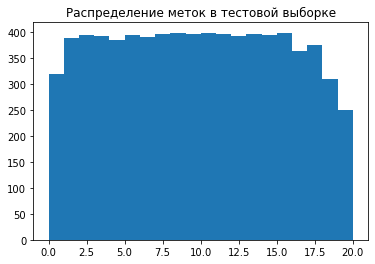

In [17]:
plt.hist(test_source["target"], bins=np.arange(0, 21))
plt.title("Распределение меток в тестовой выборке")

### PyTorch Dataset

In [18]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source["target"])
test_dataset = SparseFeaturesDataset(test_vectors, test_source["target"])

## Обучение модели на PyTorch

In [19]:
class MLP(torch.nn.Module):
    def __init__(self, vocab_size, num_of_labels):
        super().__init__()
        self.layers = nn.Sequential(
            torch.nn.Linear(vocab_size, 100),
            torch.nn.Sigmoid(),
            torch.nn.Linear(100, num_of_labels)
        )

    def forward(self, x):
        """
        Forward pass
        """
        return self.layers(x)

In [20]:
class LogReg(torch.nn.Module):
    def __init__(self, vocab_size, num_of_labels):
        super().__init__()
        self.layers = nn.Sequential(torch.nn.Linear(vocab_size, num_of_labels))

    def forward(self, x):
        """
        Forward pass
        """
        return self.layers(x)

In [21]:
model = LogReg(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

In [22]:
l2_reg_alpha = 1e-4
lr = 1e-1
epoch_n = 200
batch_size = 32
device="cpu"
optimizer_ctor = torch.optim.Adagrad

In [23]:
scheduler = lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(
    optim, patience=5, factor=0.5, verbose=True
)

best_val_loss, best_model = train_eval_loop(
    model=model,
    train_dataset=train_dataset,
    val_dataset=test_dataset,
    criterion=F.cross_entropy,
    lr=lr,
    epoch_n=epoch_n,
    batch_size=batch_size,
    device=device,
    l2_reg_alpha=l2_reg_alpha,
    optimizer_ctor=optimizer_ctor,
    lr_scheduler_ctor=scheduler,
)

Эпоха 0
Эпоха: 354 итераций, 2.16 сек
Среднее значение функции потерь на обучении 1.1393288836977575
Среднее значение функции потерь на валидации 1.077737490504475
Новая лучшая модель!

Эпоха 1
Эпоха: 354 итераций, 1.97 сек
Среднее значение функции потерь на обучении 0.5145459441141894
Среднее значение функции потерь на валидации 1.0238494575023651
Новая лучшая модель!

Эпоха 2
Эпоха: 354 итераций, 1.96 сек
Среднее значение функции потерь на обучении 0.4244963117575241
Среднее значение функции потерь на валидации 0.9907745842711401
Новая лучшая модель!

Эпоха 3
Эпоха: 354 итераций, 1.97 сек
Среднее значение функции потерь на обучении 0.3737986411920375
Среднее значение функции потерь на валидации 0.9690432321217101
Новая лучшая модель!

Эпоха 4
Эпоха: 354 итераций, 1.99 сек
Среднее значение функции потерь на обучении 0.34197615124916625
Среднее значение функции потерь на валидации 0.9535212612758248
Новая лучшая модель!

Эпоха 5
Эпоха: 354 итераций, 2.12 сек
Среднее значение функции по

Среднее значение функции потерь на валидации 0.8912023981496439
Новая лучшая модель!

Эпоха 45
Эпоха: 354 итераций, 2.05 сек
Среднее значение функции потерь на обучении 0.22116521295517852
Среднее значение функции потерь на валидации 0.8912812859072523

Эпоха 46
Эпоха: 354 итераций, 2.18 сек
Среднее значение функции потерь на обучении 0.220879735961809
Среднее значение функции потерь на валидации 0.891896525555748

Эпоха 47
Эпоха: 354 итераций, 2.09 сек
Среднее значение функции потерь на обучении 0.22071595548909936
Среднее значение функции потерь на валидации 0.8911652861762855
Новая лучшая модель!

Эпоха 48
Эпоха: 354 итераций, 2.06 сек
Среднее значение функции потерь на обучении 0.22048942967828383
Среднее значение функции потерь на валидации 0.8913356114999723

Эпоха 49
Эпоха: 354 итераций, 2.06 сек
Среднее значение функции потерь на обучении 0.2203538379931854
Среднее значение функции потерь на валидации 0.8908772956011659
Новая лучшая модель!

Эпоха 50
Эпоха: 354 итераций, 2.35 с

## Оценка качества

In [24]:
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(
    torch.from_numpy(train_pred), torch.from_numpy(train_source["target"]).long()
)

print("Среднее значение функции потерь на обучении", float(train_loss))
print(
    "Доля верных ответов", accuracy_score(train_source["target"], train_pred.argmax(-1))
)
print()


test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(
    torch.from_numpy(test_pred), torch.from_numpy(test_source["target"]).long()
)

print("Среднее значение функции потерь на валидации", float(test_loss))
print(
    "Доля верных ответов", accuracy_score(test_source["target"], test_pred.argmax(-1))
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/353.5625 [00:01<00:00, 186.78it/s]


Среднее значение функции потерь на обучении 0.20902428030967712
Доля верных ответов 0.9983206646632491



236it [00:01, 180.24it/s]                                                                                                                                                                                   

Среднее значение функции потерь на валидации 0.8890129923820496
Доля верных ответов 0.8113382899628253


In [25]:
print(f"- среднее значение функции потерь на обучении: {float(train_loss)}")
print(f"- доля верных ответов на обучении: {accuracy_score(train_source['target'], train_pred.argmax(-1))}")
print(f"- среднее значение функции потерь на валидации: {float(test_loss)}")
print(f"- доля верных ответов на валидации: {accuracy_score(test_source['target'], test_pred.argmax(-1))}")

- среднее значение функции потерь на обучении: 0.20902428030967712
- доля верных ответов на обучении: 0.9983206646632491
- среднее значение функции потерь на валидации: 0.8890129923820496
- доля верных ответов на валидации: 0.8113382899628253


# Альтернативная реализация на scikit-learn

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

sklearn_pipeline = Pipeline(
    (
        (
            "vect",
            TfidfVectorizer(
                tokenizer=tokenize_text_simple_regex, max_df=MAX_DF, min_df=MIN_COUNT
            ),
        ),
        ("cls", LogisticRegression()),
    )
)
sklearn_pipeline.fit(train_source["data"], train_source["target"])

## Оценка качества

In [16]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source["data"])
sklearn_train_loss = F.cross_entropy(
    torch.from_numpy(sklearn_train_pred), torch.from_numpy(train_source["target"])
)
print("Среднее значение функции потерь на обучении", float(sklearn_train_loss))
print(
    "Доля верных ответов",
    accuracy_score(train_source["target"], sklearn_train_pred.argmax(-1)),
)
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source["data"])
sklearn_test_loss = F.cross_entropy(
    torch.from_numpy(sklearn_test_pred), torch.from_numpy(test_source["target"])
)
print("Среднее значение функции потерь на валидации", float(sklearn_test_loss))
print(
    "Доля верных ответов",
    accuracy_score(test_source["target"], sklearn_test_pred.argmax(-1)),
)

Среднее значение функции потерь на обучении 2.4954788917367474
Доля верных ответов 0.9716280714159449

Среднее значение функции потерь на валидации 2.653902258130049
Доля верных ответов 0.8190387679235263
